# Project Milestone Two: Modeling and Feature Engineering

### Due: Midnight on April 13 (with 2-hour grace period) and worth 25 points

### Overview

This milestone builds on your work from Milestone 1. You will:

1. Evaluate baseline models using default settings.
2. Engineer new features and re-evaluate models.
3. Use feature selection techniques to find promising subsets.
4. Select the top 3 models and fine-tune them for optimal performance.

You must do all work in this notebook and upload to your team leader's account in Gradescope. There is no
Individual Assessment for this Milestone.


In [1]:
# ===================================
# Useful Imports: Add more as needed
# ===================================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Progress Tracking

from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Load your Preprocessed Dataset from Milestone 1

In Milestone 1, you handled missing values, encoded categorical features, and explored your data. Before you begin this milestone, you’ll need to load that cleaned dataset and prepare it for modeling.

Here’s what to do:

1. Return to your Milestone 1 notebook and rerun your code through Part 3, where your dataset was fully cleaned (assume it’s called `df_cleaned`).

2. **Save** the cleaned dataset to a file by running:

>   df_cleaned.to_csv("zillow_cleaned.csv", index=False)

3. Switch to this notebook and **load** the saved data:

>   df = pd.read_csv("zillow_cleaned.csv")

4. Create a **train/test split** using `train_test_split`.  
   
6. **Standardize** the features (but not the target!) using **only the training data.** This ensures consistency across models without introducing data leakage from the test set:

>   scaler = StandardScaler()   
>   X_train_scaled = scaler.fit_transform(X_train)    
  
**Notes:**

- You will not use the testing set during this milestone — it’s reserved for final evaluation later.
- You will have to redo the scaling step when you introduce new features (which have to be scaled as well).


In [2]:
# Create a function for reading the dataset and splitting into training and testing sets with scaled and unscaled data
def load_data(path, target_column='taxvaluedollarcnt', random_state=random_state):
    # Load the dataset
    df = pd.read_csv(path)

    # check if the dataset has been loaded properly
    if df.empty:
        raise ValueError("the dataset is empty, please check the path or the file content.")
    print(f"loaded dataset with shape: {df.shape}")

    # Split the data into features and target variables
    X = df.drop(columns=target_column)
    y = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    # create scaled versions of the train and test features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)

    return X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, df

In [3]:
# Load the data from github and preprocess the data
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, df = load_data(
    'https://raw.githubusercontent.com/ys1433/Module-3-Assignments/refs/heads/main/zillow_cleaned.csv',
    target_column='taxvaluedollarcnt'
)
df.describe()

loaded dataset with shape: (71217, 25)


,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fireplacecnt,fullbathcnt,garagecarcnt,...,poolcnt,propertylandusetypeid,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,unitcnt,yearbuilt,taxvaluedollarcnt
count,71217.000000,71217.000000,71217.00000,71217.000000,71217.000000,71217.000000,71217.000000,71217.000000,71217.000000,71217.000000,...,71217.000000,71217.000000,71217.000000,71217.000000,71217.000000,71217.000000,71217.000000,71217.000000,71217.000000,7.121700e+04
mean,0.477218,2.245131,2.99246,7.102546,2.245131,1710.609686,1710.609686,0.134280,2.176362,0.627112,...,0.212632,262.552157,33532.175731,2516.740202,103170.624767,96594.172108,1.553632,0.639988,1969.475715,4.385738e+05
std,25.523502,0.879714,0.99756,1.484871,0.879714,815.711711,815.711711,0.406862,0.863613,0.921040,...,0.409172,2.445314,46197.448333,806.793482,124433.701431,3432.173590,2.875226,0.481759,22.886402,3.574787e+05
min,0.000000,1.000000,0.00000,1.000000,1.000000,152.000000,152.000000,0.000000,1.000000,0.000000,...,0.000000,246.000000,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,0.000000,1878.000000,1.000000e+03
25%,0.000000,2.000000,2.00000,6.000000,2.000000,1165.000000,1165.000000,0.000000,2.000000,0.000000,...,0.000000,261.000000,12447.000000,1286.000000,48570.000000,96208.000000,0.000000,0.000000,1954.000000,2.035000e+05
50%,0.000000,2.000000,3.00000,8.000000,2.000000,1507.000000,1507.000000,0.000000,2.000000,0.000000,...,0.000000,261.000000,25218.000000,3101.000000,48570.000000,96410.000000,0.000000,1.000000,1971.000000,3.530000e+05
75%,0.000000,3.000000,4.00000,8.000000,3.000000,2033.000000,2033.000000,0.000000,3.000000,2.000000,...,0.000000,266.000000,45457.000000,3101.000000,51906.000000,96989.000000,0.000000,1.000000,1987.000000,5.535430e+05
max,3560.000000,10.000000,11.00000,12.000000,10.000000,11020.000000,11020.000000,5.000000,10.000000,14.000000,...,1.000000,275.000000,396556.000000,3101.000000,764167.000000,399675.000000,14.000000,6.000000,2016.000000,2.450000e+06


In [4]:
# square footage features have large values and are highly skewed, consider log transformation

# basementsqft, fireplacecnt, garagecarcnt, poolcnt have a lot of zeros (> 75%)), consider transforming them to binary features
zero_list = [
    'basementsqft',
    'fireplacecnt',
    'garagecarcnt',
]
# Check the percentage of zeros in the zero_list features
for col in zero_list:
    zero_percentage = (df[col] == 0).mean() * 100
    print(f"{col}: {zero_percentage:.2f}% zeros")

basementsqft: 99.93% zeros
fireplacecnt: 88.62% zeros
garagecarcnt: 65.57% zeros


### Part 1: Baseline Modeling [3 pts]

Apply the following regression models to the scaled training dataset using **default parameters**:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree Regression
- Bagging
- Random Forest
- Gradient Boosting Trees

For each model:
- Use **repeated cross-validation** (e.g., 5 folds, 5 repeats).
- Report the **mean and standard deviation of CV RMSE Score** across all folds in a table.


In [5]:
# def run_model(model, X_train, y_train, n_repeats=5, n_jobs=-1, return_model=False, **model_params):

#     # Instantiate the model if a class is provided, so for example can use either BaggingRegressor or BaggingRegressor() as argument.
#     if isinstance(model, type):
#         model = model(**model_params)

#     neg_rmse_scores = cross_val_score(model, X_train, y_train, scoring = 'neg_root_mean_squared_error',
#                                      cv = RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=random_state), n_jobs = n_jobs)

#     mean_cv_rmse = -np.mean(neg_rmse_scores)
#     std_cv_rmse  = np.std(neg_rmse_scores)

#     # Fit the model on the full training set
#     model.fit(X_train, y_train)

#     # Compute training RMSE
#     train_preds = model.predict(X_train)
#     train_rmse = root_mean_squared_error(y_train, train_preds)

#     if return_model:
#         return mean_cv_rmse, std_cv_rmse, train_rmse, model
#     else:
#         return mean_cv_rmse, std_cv_rmse, train_rmse

In [6]:
def run_model(model, x_train, y_train, return_model=False, n_repeats=5, n_jobs=-1, random_state=random_state, **model_params):

    # Instantiate the model if a class is provided, so for example can use either BaggingRegressor or BaggingRegressor() as argument. 
    if isinstance(model, type):
        model = model(**model_params)

    neg_rmse_scores = cross_val_score(model, x_train, y_train, scoring = 'neg_root_mean_squared_error',
                                     cv = RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=random_state), n_jobs = n_jobs)
    
    mean_cv_rmse = -np.mean(neg_rmse_scores)
    std_cv_rmse  = np.std(neg_rmse_scores)
    
    # Fit the model on the full training set
    model.fit(x_train, y_train)
    
    # Compute training RMSE
    if return_model:
        train_preds = model.predict(x_train)
        train_rmse = root_mean_squared_error(y_train, train_preds)
    
        return mean_cv_rmse, std_cv_rmse, train_rmse, model
    
    else:
        train_preds = model.predict(x_train)
        train_rmse = root_mean_squared_error(y_train, train_preds)

        return mean_cv_rmse, std_cv_rmse, train_rmse

In [7]:
# # Create a function that runs all the models and returns a Dataframe with the results and fitted models
# def evaluate_model(model_dict, X_train, y_train, random_state=random_state, return_model=False):
#     results = {}
#     fitted_models = {}

#     for model_name, model in model_dict.items():
#         print(f"Evaluating {model_name}...")

#         if return_model:
#             mean_cv_rmse, std_cv_rmse, train_rmse, fitted_model = run_model(
#                 model,
#                 X_train = X_train,
#                 y_train = y_train,
#                 random_state=random_state,
#                 return_model=True
#                 )
#             fitted_models[model_name] = fitted_model
#         else:
#             mean_cv_rmse, std_cv_rmse, train_rmse = run_model(
#                 model,
#                 X_train = X_train,
#                 y_train = y_train,
#                 random_state=random_state,
#                 return_model=False
#             )

#         results[model_name] = {
#             'Mean CV RMSE': dollar_format(mean_cv_rmse, 2),
#             'STD CV RMSE': dollar_format(std_cv_rmse, 2),
#             'Train RMSE': dollar_format(train_rmse, 2)
#         }

#     results_df = pd.DataFrame(results).T
#     results_df.index.name = 'Model'
#     results_df = results_df.sort_values(by='Mean CV RMSE', ascending=True)
#     print("Evaluation complete. Results:")
#     if return_model:
#         return results_df, fitted_models
#     else:
#         return results_df

In [67]:
def evaluate_model(
    models, 
    x_train, y_train, 
    evaluate=False,
    return_model=False,
    random_state=random_state, 
    **model_params
):

    results = {}
    fitted_models = {}

    for name, model in models.items():
        print(f"Evaluating {name}…")

        if return_model:
            # run_model must accept x_test, y_test, test=True
            mean_cv_rmse, std_cv_rmse, train_rmse, fitted_model = run_model(
                model,
                x_train, y_train,
                return_model=True,
                random_state=random_state,
                **model_params
            )
            fitted_models[name] = fitted_model
        else:
            # only get the three training‐set metrics
            mean_cv_rmse, std_cv_rmse, train_rmse = run_model(
                model,
                x_train, y_train,
                return_model=False,
                random_state=random_state,
                **model_params
            )
        # now format only the things you actually have
        row = {
            'Mean CV RMSE': dollar_format(mean_cv_rmse, 2),
            'STD CV RMSE' : dollar_format(std_cv_rmse, 2),
            'Train RMSE': dollar_format(train_rmse, 2),
        }

        results[name] = row

    df = pd.DataFrame(results).T
    df.index.name = 'Model'
    sort_col = 'Test RMSE' if evaluate else 'Mean CV RMSE'

    if return_model:
        return df.sort_values(by=sort_col), fitted_models
    else:
        return df.sort_values(by=sort_col)


In [9]:
# models with default parameters
model_dict = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Bagging": BaggingRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
    }

In [12]:
baseline_results, baseline_model = evaluate_model(model_dict, X_train_scaled, y_train, return_model=True, random_state=random_state)
print(baseline_results)

Evaluating Linear…
Evaluating Ridge…
Evaluating Lasso…
Evaluating Decision Tree…
Evaluating Bagging…
Evaluating Random Forest…
Evaluating Gradient Boosting…
                  Mean CV RMSE STD CV RMSE Train RMSE
Model                                                
Random Forest         $241,762      $2,501    $91,876
Gradient Boosting     $245,811      $2,741   $242,356
Bagging               $251,868      $2,191   $107,384
Linear                $276,212      $2,985   $276,019
Ridge                 $276,212      $2,985   $276,019
Lasso                 $276,212      $2,985   $276,019
Decision Tree         $332,750      $3,307    $24,216


### Part 1: Discussion [2 pts]

In a paragraph or well-organized set of bullet points, briefly compare and discuss:

  - Which models perform best overall?
  - Which are most stable (lowest std)?
  - Any signs of overfitting or underfitting?

### **Answer**

* Models with overall best performance: The top three best-performing models, based on mean cross-validation RMSE, were all ensemble methods: Random Forest, Gradient Boosting, and Bagging. Random Forest stood out with top-2 rankings across all metrics, including the lowest mean CV RMSE and lowest standard deviation, making it highly accurate and stable. However, there is a large gap between its training RMSE and the mean CV RMSE, suggesting potential overfitting to the training data. Taking into account performance, stability, and signs of overfitting, Gradient Boosting emerges as the most well-rounded model. It achieved strong performance with a mean CV RMSE only slightly higher than Random Forest’s, while maintaining a training RMSE that closely matches its CV RMSE—indicating better generalization and less overfitting.

* Most stable model: The most stable models, as measured by standard deviation in CV RMSE, were again the top-performing ensemble models: Random Forest, Bagging, and Gradient Boosting. Among them, Random Forest was the most stable, with the lowest standard deviation, followed by Bagging and Gradient Boosting.

* The Decision Tree model had a very low training RMSE but performed significantly worse on validation data—an obvious sign of overfitting. Random Forest and Bagging also showed signs of overfitting, though to a lesser degree. In contrast, the Linear, Ridge, and Lasso models had nearly identical RMSE values on both training and validation sets. However, those values were relatively high, suggesting these models are underfitting.

### Part 2: Feature Engineering [3 pts]

Consider **at least three new features** based on your Milestone 1, Part 5. Examples include:
- Polynomial terms
- Log or interaction terms
- Groupings or transformations of categorical features

Add these features to `X_train` and then:
- Scale using `StandardScaler`
- Re-run all models listed above (using default settings again).
- Report updated RMSE scores (mean and std) across repeated CV in a table.

**Note:**  Recall that this will require creating a new version of the dataset, so effectively you may be running "polynomial regression" using `LinearRegression`.

### creat new features using log transformation, polynominal terms, one-hot code

(56973, 27)

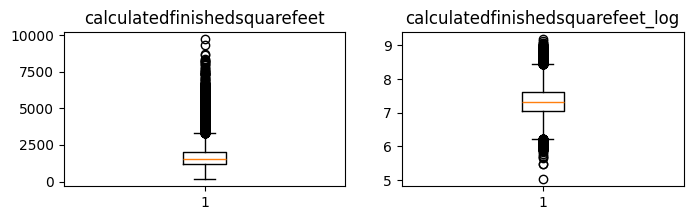

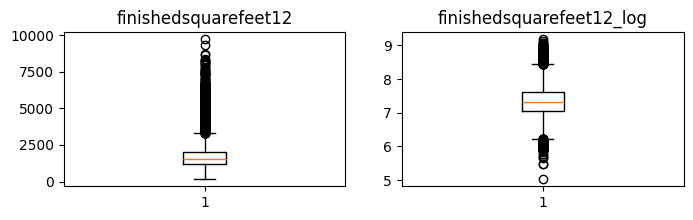

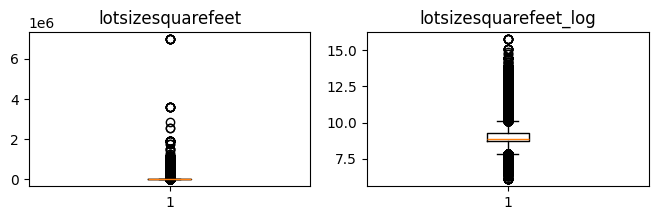

In [13]:
# log transfermation of square footage features

# define log transformation function
def log_transformation(df, column):
  df[f'{column}_log_transformed'] = np.log(df[column])
  fig, axes = plt.subplots(1, 2, figsize=(8,2))
  axes[0].boxplot(df[column])
  axes[0].set_title(column)
  axes[1].boxplot(df[f'{column}_log_transformed'])
  axes[1].set_title(f'{column}_log')

# apply log transformation to selected columns with large values and high skewness
# (all square footage columns except for basementsqft as it has only 38 non-zero rows)
X_train_log = X_train.copy()
log_list = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'lotsizesquarefeet']

for f in log_list:
    log_transformation(X_train_log, f)

X_train_log.shape

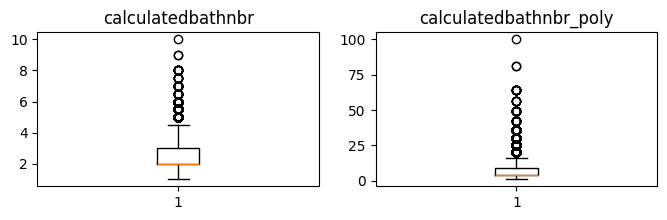

In [14]:
# polynomial transformation

# define polynomial transformation function
def polynomial_transformation(df, column, degree):
  df[f'{column}_poly_transformed'] = df[column]**degree
  fig, axes = plt.subplots(1, 2, figsize=(8,2))
  axes[0].boxplot(df[column])
  axes[0].set_title(column)
  axes[1].boxplot(df[f'{column}_poly_transformed'])
  axes[1].set_title(f'{column}_poly')

# apply polynomial transformation to selected columns
X_train_poly = X_train_log.copy()
poly_list = ['calculatedbathnbr']
for f in poly_list:
  polynomial_transformation(X_train_poly, f, 2)

In [15]:
# encoder for Categorical features

# define one-hot encoding function
def one_hot_encode(df, columns):
    df = df.copy()
    df[columns] = df[columns].astype(str)

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded = encoder.fit_transform(df[columns])
    encoded_df = pd.DataFrame(
        encoded,
        columns=encoder.get_feature_names_out(columns),
        index=df.index
    )

    df = pd.concat([df, encoded_df], axis=1)
    return df

# apply one-hot encoding to selected categorical features (id type features without too many unique values)
encode_list = ['regionidcounty', 'heatingorsystemtypeid', 'propertylandusetypeid' ]
X_train_encoded = one_hot_encode(X_train_poly, encode_list)
X_train_encoded.shape

(56973, 51)

In [16]:
# convert zero_list features to binary features
def convert_to_binary(df, column):
        df[f'{column}_binary'] = (df[column] != 0).astype(int)

X_train_binary = X_train_encoded.copy()
print(zero_list)
for f in zero_list:
    convert_to_binary(X_train_binary, f)

X_train_binary.shape
print(X_train_binary.info())

['basementsqft', 'fireplacecnt', 'garagecarcnt']
<class 'pandas.core.frame.DataFrame'>
Index: 56973 entries, 26945 to 15795
Data columns (total 54 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   basementsqft                                  56973 non-null  float64
 1   bathroomcnt                                   56973 non-null  float64
 2   bedroomcnt                                    56973 non-null  float64
 3   buildingqualitytypeid                         56973 non-null  float64
 4   calculatedbathnbr                             56973 non-null  float64
 5   calculatedfinishedsquarefeet                  56973 non-null  float64
 6   finishedsquarefeet12                          56973 non-null  float64
 7   fireplacecnt                                  56973 non-null  float64
 8   fullbathcnt                                   56973 non-null  float64
 9   garagecarcnt 

In [17]:
# Standardize the transformed features
scaler = StandardScaler()
X_train_transformed_scaled = scaler.fit_transform(X_train_binary)

X_train_transformed_scaled = pd.DataFrame(X_train_transformed_scaled, columns = X_train_binary.columns)

print(X_train_transformed_scaled.shape)
print(y_train.shape)

(56973, 54)
(56973,)


In [18]:
# create a list of all transformed features
transformed_features = log_list + poly_list + encode_list + zero_list
print(len(transformed_features), transformed_features)

# create a df without the orginal features
X_train_transformed_scaled_original_dropped = X_train_transformed_scaled.drop(columns=transformed_features)
X_train_transformed_scaled_original_dropped.shape

10 ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'lotsizesquarefeet', 'calculatedbathnbr', 'regionidcounty', 'heatingorsystemtypeid', 'propertylandusetypeid', 'basementsqft', 'fireplacecnt', 'garagecarcnt']


(56973, 44)

### re-fun models using new features

In [19]:
# evaluate the models again with the transformed features only
model_dict_transformed_feature = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Bagging": BaggingRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
    }

transformed_features_results, transformed_features_model = evaluate_model(model_dict_transformed_feature, X_train_transformed_scaled_original_dropped, y_train, return_model=True)

Evaluating Linear…
Evaluating Ridge…
Evaluating Lasso…


c:\Users\JT von Seggern\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.782e+15, tolerance: 7.293e+11
  model = cd_fast.enet_coordinate_descent(


Evaluating Decision Tree…
Evaluating Bagging…
Evaluating Random Forest…
Evaluating Gradient Boosting…


In [20]:
print("transformed features model results:")
print(transformed_features_results)
print("================================")
print('baseline model results:')
print(baseline_results)

transformed features model results:
                  Mean CV RMSE STD CV RMSE Train RMSE
Model                                                
Random Forest         $241,785      $2,365    $92,347
Gradient Boosting     $245,615      $2,644   $242,368
Bagging               $252,588      $2,770   $106,307
Linear                $278,011      $3,021   $277,717
Ridge                 $278,011      $3,021   $277,717
Lasso                 $278,011      $3,021   $277,717
Decision Tree         $332,885      $2,835    $24,225
baseline model results:
                  Mean CV RMSE STD CV RMSE Train RMSE
Model                                                
Random Forest         $241,762      $2,501    $91,876
Gradient Boosting     $245,811      $2,741   $242,356
Bagging               $251,868      $2,191   $107,384
Linear                $276,212      $2,985   $276,019
Ridge                 $276,212      $2,985   $276,019
Lasso                 $276,212      $2,985   $276,019
Decision Tree         

In [21]:
# check which new features contribute to the model performance
gb_model = transformed_features_model['Gradient Boosting']
importances = pd.Series(gb_model.feature_importances_, index=X_train_transformed_scaled_original_dropped.columns)
importances = importances.sort_values(ascending=False)
print(importances.head(10))

calculatedfinishedsquarefeet_log_transformed    0.366456
finishedsquarefeet12_log_transformed            0.232282
regionidzip                                     0.159170
buildingqualitytypeid                           0.061200
yearbuilt                                       0.040027
bathroomcnt                                     0.034986
calculatedbathnbr_poly_transformed              0.034535
regionidcity                                    0.023920
regionidneighborhood                            0.016665
lotsizesquarefeet_log_transformed               0.006053
dtype: float64


### Part 2: Discussion [2 pts]

Reflect on the impact of your new features:

- Did any models show notable improvement in performance?

- Which new features seemed to help — and in which models?

- Do you have any hypotheses about why a particular feature helped (or didn’t)?

- Were there any unexpected results?



### **Answer**

#### re-run models with original features removed
* Improvement in performance: No noticeable improvements were made when evaluating models with transformed features, in some cases, models regressed in performance. Only Gradient Boosting showed a slight improvement in mean CV RMSE. Bagging remained nearly the same, while Random Forest and Decision Tree performed slightly worse in terms of mean CV RMSE but showed improved stability with lower standard deviation. Linear models got slightly worse, could be due to the new features introduced more complexity or multicollinearity, which linear models are sensitive to.

* Contribution of the new feature: Gradient Boosting was the only model that showed an improvement in performance. Feature importance analysis suggests that the log transformation of square footage features and the polynomial term for bathroom count might be the key contributors to this improvement.

* Hypotheses: Log-transforming square footage features reduced skew and compressed extreme values, and adding a polynomial term for bathroom count helped capture nonlinear effects. Tree-based models are relatively unaffected by feature scaling, as they rely on split points rather than distances or magnitudes. As a result, the tree-based models in our analysis showed only slight improvements from scaling alone. As for the linear models, they tend to suffer from multicollinearity, as observed in Milestone 1, where several clusters of features were found to be highly correlated.

* Expected results: The results were somewhat surprising as we were expecting more than negligible differences between the raw vs transformed features.

#### re-run models with all features (original + transformed): results presented in part 3
* Random Forest performance remained unchanged, while Decision Tree performed slightly worse. However, all other models showed slight improvements. As with previous results, feature importance analysis suggests that log-transformed features and the polynomial term likely contributed to these improvements.

### Part 3: Feature Selection [3 pts]

Using the full set of features (original + engineered):
- Apply **feature selection** methods to investigate whether you can improve performance.
  - You may use forward selection, backward selection, or feature importance from tree-based models.
- For each model, identify the **best-performing subset of features**.
- Re-run each model using only those features.
- Report updated RMSE scores (mean and std) across repeated CV in a table.


### re-run model with full set of features (original + engineered)

In [22]:
# evaluate model use all set of features
model_dict_all_feature = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Bagging": BaggingRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
    }

all_features_results, all_features_fitted_models = evaluate_model(model_dict_all_feature, X_train_transformed_scaled, y_train, return_model=True)

Evaluating Linear…
Evaluating Ridge…
Evaluating Lasso…


c:\Users\JT von Seggern\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.805e+15, tolerance: 7.293e+11
  model = cd_fast.enet_coordinate_descent(


Evaluating Decision Tree…
Evaluating Bagging…
Evaluating Random Forest…
Evaluating Gradient Boosting…


In [23]:
print("Results with all features:")
print(all_features_results)
print("================================")
print("Baseline model results:")
print(baseline_results)

Results with all features:
                  Mean CV RMSE STD CV RMSE Train RMSE
Model                                                
Random Forest         $241,768      $2,529    $92,109
Gradient Boosting     $245,740      $2,779   $242,307
Bagging               $252,242      $2,302   $106,671
Linear                $274,642      $2,890   $274,258
Ridge                 $274,642      $2,890   $274,258
Lasso                 $274,642      $2,890   $274,258
Decision Tree         $332,941      $3,463    $24,216
Baseline model results:
                  Mean CV RMSE STD CV RMSE Train RMSE
Model                                                
Random Forest         $241,762      $2,501    $91,876
Gradient Boosting     $245,811      $2,741   $242,356
Bagging               $251,868      $2,191   $107,384
Linear                $276,212      $2,985   $276,019
Ridge                 $276,212      $2,985   $276,019
Lasso                 $276,212      $2,985   $276,019
Decision Tree         $332,750 

### identify best features using feature importance and forward selection

In [24]:
# feature importance for tree-based models

# dictionary to store best features per model (using importance thresholding)
best_features_dict_feature_importances = {}

for model_name, model_obj in all_features_fitted_models.items():

    # 1. Random Forest, Gradient Boosting, Decision Tree (have .feature_importances_)
    if hasattr(model_obj, "feature_importances_"):
        importances = pd.Series(model_obj.feature_importances_, index=X_train_transformed_scaled.columns)
        best_features = importances[importances >= 0.01].sort_values(ascending=False)

    # 2. BaggingRegressor (average feature importances across base estimators)
    elif "Bagging" in model_name and hasattr(model_obj, "estimators_"):
        base_importances = np.mean([
            est.feature_importances_ for est in model_obj.estimators_
            if hasattr(est, "feature_importances_")
        ], axis=0)
        importances = pd.Series(base_importances, index=X_train_transformed_scaled.columns)
        best_features = importances[importances >= 0.01].sort_values(ascending=False)

    else:
        print(f"{model_name} does not support feature importance.")
        continue

    # Save best features to dictionary
    best_features_dict_feature_importances[f'{model_name}_feature_importances'] = list(best_features.index)

# Display results
for k, v in best_features_dict_feature_importances.items():
    print(f"\n{k} - Top Features:")
    print(v)

Linear does not support feature importance.
Ridge does not support feature importance.
Lasso does not support feature importance.

Decision Tree_feature_importances - Top Features:
['calculatedfinishedsquarefeet', 'regionidzip', 'yearbuilt', 'finishedsquarefeet12_log_transformed', 'calculatedfinishedsquarefeet_log_transformed', 'lotsizesquarefeet', 'lotsizesquarefeet_log_transformed', 'regionidcity', 'regionidneighborhood', 'buildingqualitytypeid', 'finishedsquarefeet12', 'bedroomcnt', 'poolcnt']

Bagging_feature_importances - Top Features:
['finishedsquarefeet12', 'calculatedfinishedsquarefeet_log_transformed', 'regionidzip', 'yearbuilt', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12_log_transformed', 'lotsizesquarefeet_log_transformed', 'lotsizesquarefeet', 'regionidcity', 'buildingqualitytypeid', 'regionidneighborhood', 'bedroomcnt', 'poolcnt']

Random Forest_feature_importances - Top Features:
['regionidzip', 'finishedsquarefeet12', 'finishedsquarefeet12_log_transformed', '

In [25]:
#forward selection
def forward_feature_selection(X, y, model,
                              scoring='neg_root_mean_squared_error',
                              cv=3,
                              tol=1e-4 ,               # None = no delta cutoff
                                                      # use 0.0 for "no further improvements"
                                                      # and 1e-4 for "point of diminishing returns"
                              max_features=None,      # None = use all features
                              n_jobs=-1,
                              verbose=False
                             ):
    selected_features = []                            # List to store the order of features selected
    remaining_features = list(X.columns)              # Features not yet selected
    best_scores = []                                  # List to store the CV score after each feature addition
    previous_score = float('inf')                     # Initialize previous score for improvement comparison

    # Track the best subset of features and its corresponding score

    best_feature_set = None                           # Best combination of features found so far
    best_score = float('inf')                         # Best CV score observed so far

    while remaining_features:
        scores = {}                                   # Dictionary to hold CV scores for each candidate feature
        for feature in remaining_features:
            current_features = selected_features + [feature]

            # Compute the CV score for the current set of features (negated MSE, so lower is better)
            cv_score = -cross_val_score(model, X[current_features], y,
                                        scoring=scoring, cv=cv, n_jobs=n_jobs
                                       ).mean()
            scores[feature] = cv_score

        # Select the feature that minimizes the CV score
        best_feature = min(scores, key=scores.get)
        current_score = scores[best_feature]

        # Check if the improvement is significant based on the tolerance (tol)
        if tol is not None and previous_score - current_score < tol:
            if verbose:
                print("Stopping early due to minimal improvement.")
            break

        # Add the best feature to the selected list and update score trackers
        selected_features.append(best_feature)
        best_scores.append(current_score)
        remaining_features.remove(best_feature)
        previous_score = current_score

        if verbose:
            print(f"\nFeatures: {selected_features[-3:]}, CV Score (RMSE): {current_score:.4f}")

        # Update the best subset if the current score is better than the best so far
        if current_score < best_score:
            best_score = current_score
            best_feature_set = selected_features.copy()

        # Check if the maximum number of features has been reached
        if max_features is not None and len(selected_features) >= max_features:
            break

    return (
        selected_features,      # List of features in the order they were selected (this will be ALL features if max_features == None
        best_scores,            # List of cross-validation scores corresponding to each addition in the previous list
        best_feature_set,       # The subset of features that achieved the best CV score.
        best_score              # The best CV score

    )

In [26]:
# forward selection for all models

# Dictionary to store best features per model
best_features_dict_forward_selection_all = {}

# Run forward selection for all models
for model_name, model in model_dict.items():
    print(f"Running forward feature selection for {model_name}...")

    selected_features, best_scores, best_features, best_score = forward_feature_selection(
        X_train_transformed_scaled,
        y_train,
        model
    )

    print(f"Best feature set for {model_name}: {best_features}")
    print(f"Best CV score (RMSE) for {model_name}: {dollar_format(best_score, 2)}\n")

    # Save best feature set to dictionary
    best_features_dict_forward_selection_all[model_name] = best_features

Running forward feature selection for Linear...
Best feature set for Linear: ['calculatedfinishedsquarefeet', 'bedroomcnt', 'calculatedbathnbr_poly_transformed', 'regionidneighborhood', 'buildingqualitytypeid', 'heatingorsystemtypeid_7.0', 'hashottuborspa', 'lotsizesquarefeet_log_transformed', 'roomcnt', 'garagecarcnt', 'yearbuilt', 'poolcnt', 'fireplacecnt', 'propertylandusetypeid_266.0', 'propertylandusetypeid_246.0', 'fireplacecnt_binary', 'propertylandusetypeid_265.0', 'garageunknown', 'heatingorsystemtypeid', 'regionidcity', 'regionidcounty_2061.0', 'unitcnt', 'regionidcounty', 'propertylandusetypeid_260.0', 'propertylandusetypeid_263.0', 'heatingorsystemtypeid_18.0', 'basementsqft', 'propertylandusetypeid_269.0', 'lotsizesquarefeet', 'heatingorsystemtypeid_13.0', 'heatingorsystemtypeid_24.0', 'heatingorsystemtypeid_10.0']
Best CV score (RMSE) for Linear: $274,555

Running forward feature selection for Ridge...
Best feature set for Ridge: ['calculatedfinishedsquarefeet', 'bedroomc

In [28]:
# Display results of forward selection for all models
print("Forward Selection Results for All Models:")
for k, v in best_features_dict_forward_selection_all.items():
    print(f"\n{k} - Top Features:")
    print(v)

Forward Selection Results for All Models:

Linear - Top Features:
['calculatedfinishedsquarefeet', 'bedroomcnt', 'calculatedbathnbr_poly_transformed', 'regionidneighborhood', 'buildingqualitytypeid', 'heatingorsystemtypeid_7.0', 'hashottuborspa', 'lotsizesquarefeet_log_transformed', 'roomcnt', 'garagecarcnt', 'yearbuilt', 'poolcnt', 'fireplacecnt', 'propertylandusetypeid_266.0', 'propertylandusetypeid_246.0', 'fireplacecnt_binary', 'propertylandusetypeid_265.0', 'garageunknown', 'heatingorsystemtypeid', 'regionidcity', 'regionidcounty_2061.0', 'unitcnt', 'regionidcounty', 'propertylandusetypeid_260.0', 'propertylandusetypeid_263.0', 'heatingorsystemtypeid_18.0', 'basementsqft', 'propertylandusetypeid_269.0', 'lotsizesquarefeet', 'heatingorsystemtypeid_13.0', 'heatingorsystemtypeid_24.0', 'heatingorsystemtypeid_10.0']

Ridge - Top Features:
['calculatedfinishedsquarefeet', 'bedroomcnt', 'calculatedbathnbr_poly_transformed', 'regionidneighborhood', 'buildingqualitytypeid', 'heatingorsyst

In [ ]:
# create dictionary to save feature selection results (in case no enough time to run again)
forward_selected_features = {
    "Linear": [
        'calculatedfinishedsquarefeet', 'bedroomcnt', 'calculatedbathnbr_poly_transformed',
        'regionidneighborhood', 'buildingqualitytypeid', 'heatingorsystemtypeid_7.0',
        'hashottuborspa', 'lotsizesquarefeet_log_transformed', 'roomcnt', 'garagecarcnt',
        'yearbuilt', 'poolcnt', 'fireplacecnt', 'propertylandusetypeid_266.0',
        'propertylandusetypeid_246.0', 'fireplacecnt_binary', 'propertylandusetypeid_265.0',
        'garageunknown', 'heatingorsystemtypeid', 'regionidcity', 'regionidcounty_2061.0',
        'unitcnt', 'regionidcounty', 'propertylandusetypeid_260.0', 'propertylandusetypeid_263.0',
        'heatingorsystemtypeid_18.0', 'basementsqft', 'propertylandusetypeid_269.0',
        'lotsizesquarefeet', 'heatingorsystemtypeid_13.0', 'heatingorsystemtypeid_24.0',
        'heatingorsystemtypeid_10.0'
    ],
    "Ridge": [
        'calculatedfinishedsquarefeet', 'bedroomcnt', 'calculatedbathnbr_poly_transformed',
        'regionidneighborhood', 'buildingqualitytypeid', 'heatingorsystemtypeid_7.0',
        'hashottuborspa', 'lotsizesquarefeet_log_transformed', 'roomcnt', 'garagecarcnt',
        'yearbuilt', 'poolcnt', 'fireplacecnt', 'propertylandusetypeid_266.0',
        'propertylandusetypeid_246.0', 'fireplacecnt_binary', 'propertylandusetypeid_265.0',
        'garageunknown', 'heatingorsystemtypeid', 'regionidcity', 'regionidcounty_2061.0',
        'unitcnt', 'regionidcounty_1286.0', 'propertylandusetypeid_260.0',
        'propertylandusetypeid_263.0', 'heatingorsystemtypeid_18.0', 'basementsqft',
        'propertylandusetypeid_269.0', 'lotsizesquarefeet', 'heatingorsystemtypeid_13.0',
        'heatingorsystemtypeid_24.0', 'heatingorsystemtypeid_10.0', 'finishedsquarefeet12'
    ],
    "Lasso": [
        'calculatedfinishedsquarefeet', 'bedroomcnt', 'calculatedbathnbr_poly_transformed',
        'regionidneighborhood', 'buildingqualitytypeid', 'heatingorsystemtypeid_7.0',
        'hashottuborspa', 'lotsizesquarefeet_log_transformed', 'roomcnt', 'garagecarcnt',
        'yearbuilt', 'poolcnt', 'fireplacecnt', 'propertylandusetypeid_266.0',
        'propertylandusetypeid_246.0', 'fireplacecnt_binary', 'propertylandusetypeid_265.0',
        'garageunknown', 'heatingorsystemtypeid', 'regionidcity', 'regionidcounty_2061.0',
        'unitcnt', 'regionidcounty_1286.0', 'propertylandusetypeid_260.0',
        'propertylandusetypeid_263.0', 'heatingorsystemtypeid_18.0', 'basementsqft',
        'propertylandusetypeid_269.0', 'lotsizesquarefeet', 'heatingorsystemtypeid_13.0',
        'heatingorsystemtypeid_24.0', 'heatingorsystemtypeid_10.0'
    ],
    "Decision Tree": [
        'bathroomcnt', 'regionidzip', 'propertylandusetypeid_266.0',
        'regionidcounty_1286.0', 'fullbathcnt', 'propertylandusetypeid_267.0',
        'propertylandusetypeid_246.0'
    ],
    "Bagging": [
        'calculatedbathnbr_poly_transformed', 'regionidzip',
        'propertylandusetypeid_266.0'
    ],
    "Random Forest": [
        'calculatedbathnbr_poly_transformed', 'regionidzip',
        'propertylandusetypeid', 'bathroomcnt'
    ],
    "Gradient Boosting": [
        'calculatedfinishedsquarefeet', 'regionidzip', 'yearbuilt',
        'buildingqualitytypeid', 'regionidneighborhood', 'regionidcounty',
        'propertylandusetypeid', 'regionidcity', 'propertylandusetypeid_261.0',
        'fireplacecnt_binary', 'heatingorsystemtypeid_2.0', 'basementsqft_binary',
        'taxdelinquencyflag', 'heatingorsystemtypeid_10.0'
    ]
}


importance_selected_features = {
    "Decision Tree": [
        'calculatedfinishedsquarefeet', 'regionidzip', 'yearbuilt', 'finishedsquarefeet12',
        'lotsizesquarefeet_log_transformed', 'lotsizesquarefeet', 'regionidcity',
        'finishedsquarefeet12_log_transformed', 'buildingqualitytypeid',
        'regionidneighborhood', 'calculatedfinishedsquarefeet_log_transformed',
        'bedroomcnt', 'poolcnt'
    ],
    "Bagging": [
        'finishedsquarefeet12', 'regionidzip', 'finishedsquarefeet12_log_transformed',
        'calculatedfinishedsquarefeet_log_transformed', 'yearbuilt',
        'calculatedfinishedsquarefeet', 'lotsizesquarefeet_log_transformed',
        'lotsizesquarefeet', 'regionidcity', 'buildingqualitytypeid',
        'regionidneighborhood', 'bedroomcnt'
    ],
    "Random Forest": [
        'regionidzip', 'finishedsquarefeet12', 'calculatedfinishedsquarefeet_log_transformed',
        'calculatedfinishedsquarefeet', 'finishedsquarefeet12_log_transformed', 'yearbuilt',
        'lotsizesquarefeet_log_transformed', 'lotsizesquarefeet', 'regionidcity',
        'regionidneighborhood', 'buildingqualitytypeid', 'bedroomcnt'
    ],
    "Gradient Boosting": [
        'finishedsquarefeet12_log_transformed', 'regionidzip',
        'calculatedfinishedsquarefeet_log_transformed', 'finishedsquarefeet12',
        'calculatedfinishedsquarefeet', 'buildingqualitytypeid', 'yearbuilt',
        'calculatedbathnbr', 'regionidcity', 'calculatedbathnbr_poly_transformed',
        'bathroomcnt', 'regionidneighborhood'
    ]
}

In [ ]:
print('Feature selection results_forward selection:')
for key, value in forward_selected_features.items():
    print(f"{key}: {value}")
print('\nFeature selection results_feature importance:')
for key, value in importance_selected_features.items():
    print(f"{key}: {value}")

Feature selection results_forward selection:
Linear: ['calculatedfinishedsquarefeet', 'bedroomcnt', 'calculatedbathnbr_poly_transformed', 'regionidneighborhood', 'buildingqualitytypeid', 'heatingorsystemtypeid_7.0', 'hashottuborspa', 'lotsizesquarefeet_log_transformed', 'roomcnt', 'garagecarcnt', 'yearbuilt', 'poolcnt', 'fireplacecnt', 'propertylandusetypeid_266.0', 'propertylandusetypeid_246.0', 'fireplacecnt_binary', 'propertylandusetypeid_265.0', 'garageunknown', 'heatingorsystemtypeid', 'regionidcity', 'regionidcounty_2061.0', 'unitcnt', 'regionidcounty', 'propertylandusetypeid_260.0', 'propertylandusetypeid_263.0', 'heatingorsystemtypeid_18.0', 'basementsqft', 'propertylandusetypeid_269.0', 'lotsizesquarefeet', 'heatingorsystemtypeid_13.0', 'heatingorsystemtypeid_24.0', 'heatingorsystemtypeid_10.0']
Ridge: ['calculatedfinishedsquarefeet', 'bedroomcnt', 'calculatedbathnbr_poly_transformed', 'regionidneighborhood', 'buildingqualitytypeid', 'heatingorsystemtypeid_7.0', 'hashottuborsp

### re-run models with selected features

In [38]:
def evaluate_models_with_selected_features(model_dict, best_features_dict, x_train, y_train, random_state=42):

    results = {}

    for model_name, model in model_dict.items():
        print(f"Running {model_name} with best feature set...")

        selected_features = best_features_dict.get(model_name, [])

        if selected_features:
            # X_train_subset = X_train[selected_features]
            mean_cv_rmse, std_cv_rmse, train_rmse = run_model(
                model,
                x_train,
                y_train,
                random_state=random_state
            )

            results[model_name] = {
                "Selected Features": selected_features,
                "Mean CV RMSE": dollar_format(mean_cv_rmse, 2),
                "STD CV RMSE": dollar_format(std_cv_rmse, 2),
                "Train RMSE": dollar_format(train_rmse, 2)
            }
        else:
            print(f"No features selected for {model_name}. Skipping.\n")

    return results

In [39]:
# re-run tree-based models with best features from feature importance
model_dict_tree_based = {
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Bagging": BaggingRegressor(),
    "Decision Tree": DecisionTreeRegressor()
}

tree_results_importance_best_features = evaluate_models_with_selected_features(
    model_dict_tree_based,
    best_features_dict_feature_importances,
    X_train_transformed_scaled,
    y_train,
    random_state=random_state
)

print("Tree-based models with best features from feature importance:")
print(pd.DataFrame.from_dict(tree_results_importance_best_features, orient='index'))
print("================================")
print("Baseline model results:")
print(baseline_results)

Running Random Forest with best feature set...
No features selected for Random Forest. Skipping.

Running Gradient Boosting with best feature set...
No features selected for Gradient Boosting. Skipping.

Running Bagging with best feature set...
No features selected for Bagging. Skipping.

Running Decision Tree with best feature set...
No features selected for Decision Tree. Skipping.

Tree-based models with best features from feature importance:
Empty DataFrame
Columns: []
Index: []
Baseline model results:
                  Mean CV RMSE STD CV RMSE Train RMSE
Model                                                
Random Forest         $241,762      $2,501    $91,876
Gradient Boosting     $245,811      $2,741   $242,356
Bagging               $251,868      $2,191   $107,384
Linear                $276,212      $2,985   $276,019
Ridge                 $276,212      $2,985   $276,019
Lasso                 $276,212      $2,985   $276,019
Decision Tree         $332,750      $3,307    $24,216


In [40]:
# print results
tree_results_feature_importance = [
    {"Model": "Random Forest", "Mean CV RMSE": 243673, "STD CV RMSE": 2236, "Train RMSE": 93483},
    {"Model": "Gradient Boosting", "Mean CV RMSE": 246913, "STD CV RMSE": 2924, "Train RMSE": 243990},
    {"Model": "Bagging", "Mean CV RMSE": 253911, "STD CV RMSE": 2643, "Train RMSE": 108154},
    {"Model": "Decision Tree", "Mean CV RMSE": 333473, "STD CV RMSE": 3897, "Train RMSE": 25866}
]

baseline_results_list = [
    {"Model": "Random Forest", "Mean CV RMSE": 241684, "STD CV RMSE": 2410, "Train RMSE": 92350},
    {"Model": "Gradient Boosting", "Mean CV RMSE": 245816, "STD CV RMSE": 2736, "Train RMSE": 242356},
    {"Model": "Bagging", "Mean CV RMSE": 252390, "STD CV RMSE": 2585, "Train RMSE": 106905},
    {"Model": "Linear", "Mean CV RMSE": 276212, "STD CV RMSE": 2985, "Train RMSE": 276019},
    {"Model": "Ridge", "Mean CV RMSE": 276212, "STD CV RMSE": 2985, "Train RMSE": 276019},
    {"Model": "Lasso", "Mean CV RMSE": 276212, "STD CV RMSE": 2985, "Train RMSE": 276019},
    {"Model": "Decision Tree", "Mean CV RMSE": 332369, "STD CV RMSE": 3248, "Train RMSE": 24216}
]

print("Tree-based models with best features from feature importance:")
print(pd.DataFrame(tree_results_feature_importance))
print("================================")
print("Baseline model results:")
print(pd.DataFrame(baseline_results_list))

Tree-based models with best features from feature importance:
               Model  Mean CV RMSE  STD CV RMSE  Train RMSE
0      Random Forest        243673         2236       93483
1  Gradient Boosting        246913         2924      243990
2            Bagging        253911         2643      108154
3      Decision Tree        333473         3897       25866
Baseline model results:
               Model  Mean CV RMSE  STD CV RMSE  Train RMSE
0      Random Forest        241684         2410       92350
1  Gradient Boosting        245816         2736      242356
2            Bagging        252390         2585      106905
3             Linear        276212         2985      276019
4              Ridge        276212         2985      276019
5              Lasso        276212         2985      276019
6      Decision Tree        332369         3248       24216


In [41]:
# re-run all models with best features from forward selection
model_dict_forward_features = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Bagging": BaggingRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

results_forward_best_features = evaluate_models_with_selected_features(
    model_dict_forward_features,
    best_features_dict_forward_selection_all,
    X_train_transformed_scaled,
    y_train,
    random_state=random_state
)

print("All models with best features from forward selection:")
print(pd.DataFrame.from_dict(results_forward_best_features, orient='index').sort_values(by='Mean CV RMSE'))
print("================================")
print("Baseline model results:")
print(baseline_results)

Running Linear with best feature set...
Running Ridge with best feature set...
Running Lasso with best feature set...


c:\Users\JT von Seggern\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.805e+15, tolerance: 7.293e+11
  model = cd_fast.enet_coordinate_descent(


Running Decision Tree with best feature set...
Running Bagging with best feature set...
Running Random Forest with best feature set...
Running Gradient Boosting with best feature set...
All models with best features from forward selection:
                                                   Selected Features  \
Random Forest      [calculatedbathnbr_poly_transformed, regionidz...   
Gradient Boosting  [calculatedfinishedsquarefeet, regionidzip, ye...   
Bagging            [calculatedbathnbr_poly_transformed, regionidz...   
Linear             [calculatedfinishedsquarefeet, bedroomcnt, cal...   
Ridge              [calculatedfinishedsquarefeet, bedroomcnt, cal...   
Lasso              [calculatedfinishedsquarefeet, bedroomcnt, cal...   
Decision Tree      [bathroomcnt, regionidzip, propertylandusetype...   

                  Mean CV RMSE STD CV RMSE Train RMSE  
Random Forest         $241,762      $2,442    $92,080  
Gradient Boosting     $245,741      $2,780   $242,307  
Bagging        

In [ ]:
# print results
all_results_feature_forward = [
    {"Model": "Gradient Boosting", "Mean CV RMSE": 246513, "STD CV RMSE": 2753, "Train RMSE": 243614},
    {"Model": "Random Forest", "Mean CV RMSE": 255781, "STD CV RMSE": 2767, "Train RMSE": 234818},
    {"Model": "Bagging", "Mean CV RMSE": 256916, "STD CV RMSE": 2615, "Train RMSE": 236801},
    {"Model": "Decision Tree", "Mean CV RMSE": 258655, "STD CV RMSE": 2806, "Train RMSE": 234815},
    {"Model": "Linear", "Mean CV RMSE": 274573, "STD CV RMSE": 2935, "Train RMSE": 274349},
    {"Model": "Ridge", "Mean CV RMSE": 274573, "STD CV RMSE": 2935, "Train RMSE": 274349},
    {"Model": "Lasso", "Mean CV RMSE": 274573, "STD CV RMSE": 2935, "Train RMSE": 274349}
]

print("Tree-based models with best features from feature importance:")
print(pd.DataFrame(all_results_feature_forward))
print("================================")
print("Baseline model results:")
print(pd.DataFrame(baseline_results_list))

Tree-based models with best features from feature importance:
               Model  Mean CV RMSE  STD CV RMSE  Train RMSE
0  Gradient Boosting        246513         2753      243614
1      Random Forest        255781         2767      234818
2            Bagging        256916         2615      236801
3      Decision Tree        258655         2806      234815
4             Linear        274573         2935      274349
5              Ridge        274573         2935      274349
6              Lasso        274573         2935      274349
Baseline model results:
               Model  Mean CV RMSE  STD CV RMSE  Train RMSE
0      Random Forest        241684         2410       92350
1  Gradient Boosting        245816         2736      242356
2            Bagging        252390         2585      106905
3             Linear        276212         2985      276019
4              Ridge        276212         2985      276019
5              Lasso        276212         2985      276019
6      Decisio

### Part 3: Discussion [2 pts]

Analyze the effect of feature selection on your models:

- Did performance improve for any models after reducing the number of features?

- Which features were consistently retained across models?

- Were any of your newly engineered features selected as important?

- How did feature selection differ between linear and tree-based models?

### **Answer**

* Improved performance: None of the tree-based model improved using the best features selected based on feature importances. As for the features from forward selection, simple models like Decision Tree and Linear models (Linear, Ridge, Lasso) showed slight to significant improvement. Ensemble models like Random Forest, Gradient Boosting, and Bagging actually performed slightly worse with fewer features.

* Several features were consistently retained across models and selection methods, highlighting their strong predictive power. Notably, regionidzip appeared in nearly every model, underscoring the importance of geographic location in home valuation. Property size features like calculatedfinishedsquarefeet, its log- or poly-transformed versions, and finishedsquarefeet12 were also frequently selected, along with yearbuilt and buildingqualitytypeid, which reflect the condition and quality of a property. Location identifiers such as regionidneighborhood and regionidcity also ranked highly, emphasizing regional market trends. Additionally, the engineered feature calculatedbathnbr_poly_transformed appeared in multiple models, indicating non-linear effects of bathroom count. Core structural attributes like bedroomcnt and bathroomcnt rounded out the most influential variables across both linear and tree-based approaches.

* Several of the newly engineered features proved valuable, showing up in both feature importance and forward selection methods across different models. The polynomial-transformed bathroom count (calculatedbathnbr_poly_transformed) was selected in multiple models like Bagging and Random Forest, suggesting a non-linear relationship between bathroom count and home value. Log-transformed square footage features, such as finishedsquarefeet12_log_transformed and calculatedfinishedsquarefeet_log_transformed, were also frequently retained, likely due to their ability to reduce skewness and better capture scale-related patterns. Additionally, binary indicators like fireplacecnt_binary and basementsqft_binary were selected in some models, demonstrating that simplifying sparse numerical variables into presence/absence format can make them more informative and easier for models to interpret.

* Ensemble models like Random Forest and Bagging benefited less from feature reduction, while simpler models—such as linear models and the standalone Decision Tree—actually performed better with fewer features. This is likely because forward selection helped eliminate multicollinear, redundant, or low-impact variables, simplifying the model and improving generalization. It’s also worth noting that the number of features selected for tree-based models using forward selection was significantly lower than those identified through feature importance, highlighting that some features with low global importance may still contribute meaningful splits within the ensemble.

### Part 4: Fine-Tuning Your Top 3 Models [6 pts]

In this final phase of Milestone 2, you’ll select and refine your **three most promising models and their corresponding data pipelines** based on everything you've done so far.

1. Choose the top 3 models based on performance and interpretability from earlier parts.
2. For each model:
   - Perform hyperparameter tuning using `sweep_parameters`, `GridSearchCV`, `RandomizedSearchCV`, or other techniques from previous homeworks.
   - Experiment with different versions of your feature engineering and preprocessing — treat these as additional tunable components.
3. Report the mean and standard deviation of CV RMSE score for each model in a summary table.



## **Decision Tree**



In [42]:
# Add as many code cells as you need
# Decision Tree: GridSearchCV part 1, do not run otherwise might take long time.  Should have final tunings in next cell

param_grid = {
    'max_depth': [None,3,5,10],
    'min_samples_split' : [2,4,8],
    'min_samples_leaf' : [1,2,3],
    #'max_features':
    'max_leaf_nodes' : [None, 5, 10, 20]
}

grid_search = GridSearchCV(
    estimator = DecisionTreeRegressor(random_state=random_state),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=random_state),
    n_jobs = -1,
    return_train_score = True
)

grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=42),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 5, 10],
                         'max_leaf_nodes': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 8]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [43]:
print(grid_search.best_params_, -grid_search.best_score_) #{'max_depth': 10, 'max_leaf_nodes': None, 'min_samples_leaf': 3, 'min_samples_split': 8} 260825.5907568541

# dataframe of the grid search: for viewing other top sets of features
results_search = pd.DataFrame(grid_search.cv_results_)
results_search = pd.DataFrame(grid_search.cv_results_)
results_search = results_search[[
       'param_max_depth', 'param_max_leaf_nodes', 'param_min_samples_leaf','param_min_samples_split',
       'mean_train_score', 'std_train_score',
       'mean_test_score','std_test_score', 'rank_test_score'
       ]]
results_search['mean_test_score'] = -results_search['mean_test_score']
results_search['mean_train_score'] = -results_search['mean_train_score']

results_search = results_search.sort_values(by='rank_test_score')
results_search = results_search.rename(columns = {'mean_test_score': 'RMSE Mean'})
results_search = results_search.rename(columns = {'std_test_score': 'RMSE STD'})
results_search.head(10)

{'max_depth': 10, 'max_leaf_nodes': None, 'min_samples_leaf': 3, 'min_samples_split': 8} 260825.5907568541


,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,mean_train_score,std_train_score,RMSE Mean,RMSE STD,rank_test_score
116,10,None,3,8,232993.144066,1064.743013,260825.590757,2784.186304,1
115,10,None,3,4,232592.359431,1089.973766,261003.831819,2725.139808,2
114,10,None,3,2,232592.359431,1089.973766,261003.831819,2725.139808,2
113,10,None,2,8,232780.931690,999.470024,261120.039947,2830.585074,4
110,10,None,1,8,232508.443696,1024.725443,261397.373471,2834.666606,5
111,10,None,2,2,231884.066721,988.086492,262076.030968,2791.530842,6
112,10,None,2,4,231884.066721,988.086492,262076.030968,2791.530842,6
109,10,None,1,4,231605.043191,1000.399626,262210.387023,3134.338540,8
108,10,None,1,2,231372.686279,1020.899468,262306.502799,2981.372735,9
78,5,None,3,2,267777.884066,805.319923,270427.001577,2892.896657,10


In [44]:
# final search
param_grid1 = {
    'max_depth': [None,1,2,3,4,5,6,7,8,9,10],
    'min_samples_split' : range(2,12,1),
    'min_samples_leaf' : [1,2,3,4,5],
    #'max_features':
    'max_leaf_nodes' : [None, 5, 10, 20]
}

grid_search1 = GridSearchCV(
    estimator = DecisionTreeRegressor(random_state=random_state),
    param_grid=param_grid1,
    scoring='neg_root_mean_squared_error',
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=random_state),
    n_jobs = -1,
    return_train_score = True
)


grid_search1.fit(X_train_scaled, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=42),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_leaf_nodes': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': range(2, 12)},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [45]:
print(grid_search1.best_params_, -grid_search1.best_score_) #{'max_depth': 9, 'max_leaf_nodes': None, 'min_samples_leaf': 4, 'min_samples_split': 10} 259762.68067662264
results_search1 = pd.DataFrame(grid_search1.cv_results_)
results_search1 = results_search1[[
       'param_max_depth', 'param_max_leaf_nodes', 'param_min_samples_leaf','param_min_samples_split',
       'mean_train_score', 'std_train_score',
       'mean_test_score','std_test_score', 'rank_test_score'
       ]]
results_search1['mean_test_score'] = -results_search1['mean_test_score']
results_search1['mean_train_score'] = -results_search1['mean_train_score']

results_search1 = results_search1.sort_values(by='rank_test_score')
results_search1 = results_search1.rename(columns = {'mean_test_score': 'RMSE Mean'})
results_search1 = results_search1.rename(columns = {'std_test_score': 'RMSE STD'})
results_search1.head(10)

{'max_depth': 10, 'max_leaf_nodes': None, 'min_samples_leaf': 4, 'min_samples_split': 11} 259585.32520176336


,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,mean_train_score,std_train_score,RMSE Mean,RMSE STD,rank_test_score
2039,10,None,4,11,233854.389834,1124.739444,259585.325202,2965.068508,1
1839,9,None,4,11,241808.329548,901.560394,259705.942715,2621.313680,2
2049,10,None,5,11,234117.884183,1081.026687,259743.406568,2671.673311,3
1838,9,None,4,10,241688.153011,902.823529,259762.680677,2706.630776,4
2038,10,None,4,10,233644.580101,1138.377571,259776.837477,3048.320924,5
2048,10,None,5,10,233967.665810,1089.555301,259803.958737,2631.911136,6
2041,10,None,5,3,233967.665810,1089.555301,259803.958737,2631.911136,6
2040,10,None,5,2,233967.665810,1089.555301,259803.958737,2631.911136,6
2043,10,None,5,5,233967.665810,1089.555301,259803.958737,2631.911136,6
2045,10,None,5,7,233967.665810,1089.555301,259803.958737,2631.911136,6


In [46]:
def create_score_df(fine_tuning_model, model_name): # used for grid search
  best_results = {}
  Mean =  -fine_tuning_model.best_score_
  STD = fine_tuning_model.cv_results_['std_test_score'][fine_tuning_model.best_index_]
  Train = -fine_tuning_model.cv_results_['mean_train_score'][fine_tuning_model.best_index_]

  best_results.setdefault(model_name, {})['Mean CV RMSE'] = dollar_format(Mean,2)
  best_results.setdefault(model_name, {})['STD CV RMSE'] = dollar_format(STD,2)
  best_results.setdefault(model_name, {})['Train RMSE'] = dollar_format(Train,2)
  results_df = pd.DataFrame(best_results).T
  results_df.index.name = 'Model'
  return results_df

In [47]:
dt_1 = create_score_df(grid_search, "Decision Tree 1")
dt_2 = create_score_df(grid_search1, "Decision Tree 2")

# combine Decision tree results
dt_combined = pd.concat([dt_1, dt_2]).sort_values(by='Mean CV RMSE')

# Grab the best model from the dataframe
dt_best_model = pd.DataFrame(dt_combined.iloc[0]).T
dt_best_model

,Mean CV RMSE,STD CV RMSE,Train RMSE
Decision Tree 2,"$259,585","$2,965","$233,854"


## **Bagging**

### all features

In [58]:
def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    x_train          = X_train_scaled,
                    y_train          = y_train,
                    verbose          = True,
                    show_rmse        = True,
                    n_iter_no_change = None,
                    delta            = 0.001):
    
    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary
    
    cv_rmses, std_cvs, train_rmses = [], [], []
    no_improve_count = 0
    best_rmse = float('inf')
    
    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        # Remove MSE_found if present, just in case
        P_temp.pop('RMSE_found', None)
        
        cv_rmse, std_cv, train_rmse = run_model(
            model, x_train, y_train, **P_temp
        )
        
        cv_rmses.append(cv_rmse)
        std_cvs.append(std_cv)
        train_rmses.append(train_rmse)
        
        # Early-stopping logic
        if cv_rmse < best_rmse - delta:
            best_rmse = cv_rmse
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break
    
    # Identify best parameter
    min_cv_rmse = min(cv_rmses)
    min_index = cv_rmses.index(min_cv_rmse)
    best_param = parameter_list[min_index]
    Parameters[param] = best_param
    Parameters['RMSE_found'] = min_cv_rmse
    
    if verbose:
        # Prepare for plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        
        # We only need as many parameter values as we actually computed
        partial_param_list = parameter_list[:len(cv_rmses)]
        
        # Check if our parameter list is Boolean so we can label accordingly
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            # Convert booleans to integer indices for plotting
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            # Treat numeric or other types as-is
            x_vals = partial_param_list
            x_labels = partial_param_list
        
        error_name = 'RMSE' if show_rmse else 'MSE'
        
        # ----- First plot: (R)MSE -----
        ax1.set_title(f"{error_name} vs {param}")
        
        # Apply dollar formatting ONLY if we're showing RMSE
        if show_rmse:
            ax1.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
        
        # Plot lines
        ax1.plot(x_vals,
                 cv_rmses,
                 marker='.', label=f"CV {error_name}", color='blue')
        ax1.plot(x_vals,
                 train_rmses,
                 marker='.', label=f"Train {error_name}", color='green')
        ax1.scatter([x_vals[min_index]],
                    [min_cv_rmse],
                    marker='x', label=f"Best CV {error_name}", color='red')
        
        ax1.set_ylabel(error_name)
        ax1.legend()
        ax1.grid()
        
        # ----- Second plot: CV Std Dev -----
        ax2.set_title(f"CV Standard Deviation vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label=f"CV {error_name} Std", color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(alpha=0.5)
        
        # If we are using boolean x-values, set custom ticks
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)
        
        plt.tight_layout()
        plt.show()
        
        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))
    
    return Parameters


In [54]:
Default_Parameters_Bagging = {
    'n_estimators': 10,            # Number of base estimators in the ensemble
    'max_samples' : 1.0,           # Fraction of samples to draw for each base estimator
    'max_features': 1.0,           # Fraction of features to consider for each estimator
    'bootstrap'   : True,          # Use bootstrap samples when building estimators
    'random_state': 42,            # Ensures reproducibility
    'RMSE_found'   : float('inf')   # Used for tracking the best MSE during parameter sweeps, to record result of these parameter choices
                                   # Initialized to inf in case want to use this to record best RMSE found so far in a sequence of parameter choices
}

In [55]:
Default_Parameters_GradientBoosting = {
    'learning_rate'           : 0.1,             # Shrinks the contribution of each tree. Affects the speed of learning and overfitting.
    'n_estimators'            : 100,             # The number of boosting stages to be run. More estimators can improve performance but increase training time.
    'max_depth'               : 3,               # Maximum depth of individual trees. Controls model complexity.
    'max_features'            : None,            # Number of features to consider when looking for best split. Can help reduce overfitting.
    'random_state'            : 42,              # Controls randomness of boosting. Useful for reproducibility.
    'RMSE_found'               : float('inf')     # NOT a parameter, but will record the MSE found for the current parameter choices
}

In [56]:
Parameters_BT = Default_Parameters_Bagging.copy()
Parameters_BT_list = []

In [ ]:
parameters_and_ranges = [('n_estimators', range(50, 501, 100)),
                         ('max_samples', np.linspace(.1, 1.0, 10)),
                         ('max_features', range(10, 21, 5)),
                         ('bootstrap', [True, False])
                         ]

for param, parameter_list in parameters_and_ranges:
    Parameters_BT = sweep_parameter(BaggingRegressor,
                                Parameters_BT,
                                param,
                                parameter_list,
                    )

    print(f'\nParameter {param} = {Parameters_BT[param]}; RMSE = ${Parameters_BT['RMSE_found']:,.2f}\n')
    print(Parameters_BT)

Parameters_BT_list.append(Parameters_BT)
pd.DataFrame(Parameters_BT_list)

In [ ]:
parameters_and_ranges = [('n_estimators', range(50, 250, 100)),
                         ('max_samples', [0.4]),
                         ('max_features', range(10, 21, 5)),
                         ('bootstrap', [False])
                         ]

for param, parameter_list in parameters_and_ranges:
    Parameters_BT = sweep_parameter(BaggingRegressor,
                                Parameters_BT,
                                param,
                                parameter_list,
                    )

    print(f'\nParameter {param} = {Parameters_BT[param]}; RMSE = ${Parameters_BT['RMSE_found']:,.2f}\n')
    print(Parameters_BT)

Parameters_BT_list.append(Parameters_BT)
pd.DataFrame(Parameters_BT_list)

In [61]:
# creat a dictionary to save all the results in case no enough time to run it again
bagging_results = [
    {
        'n_estimators': 450,
        'max_samples': 0.4,
        'max_features': 20,
        'bootstrap': True,
        'random_state': 42,
        'RMSE_found': 237783.480236
    },
    {
        'n_estimators': 250,
        'max_samples': 0.4,
        'max_features': 20,
        'bootstrap': False,
        'random_state': 42,
        'RMSE_found': 237832.725489
    }
]
pd.DataFrame(bagging_results)

,n_estimators,max_samples,max_features,bootstrap,random_state,RMSE_found
0,450,0.4,20,True,42,237783.480236
1,250,0.4,20,False,42,237832.725489


In [ ]:
# record beggining time
start = time.time()

# Define the parameter grid
param_dist = {
    'n_estimators': [150, 200, 250],
    'max_samples' : [0.4],
    'max_features': [15, 18, 21],
    'bootstrap': [False]
}

# Initialize the DecisionTreeRegressor
bagging_regressor = BaggingRegressor(random_state=42)

# Set up GridSearchCV with repeated CV
grid_search = GridSearchCV(estimator=bagging_regressor,
                           param_grid=param_dist,
                           scoring='neg_mean_squared_error',
                           cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42),
                           n_jobs= - 1)

# Fit the GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Extract results into a DataFrame
results = grid_search.cv_results_

# Sort indices
sorted_indices = np.argsort(results['mean_test_score'])[::-1]

print('Top 10 restuls')
for rank, idx in enumerate(sorted_indices[:10], start = 1):
    print(f"Rank {rank}: Params {results['params'][idx]}, RMSE = ${abs(results['mean_test_score'][idx]) ** 0.5:,.2f}\n")

# Record end time and print elapsed time
end = time.time()
print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))

In [62]:
# creat a dictionary to save all the results in case no enough time to run it again
BT_grid_top_10_results = {
    1: {'params': {'bootstrap': False, 'max_features': 15, 'max_samples': 0.4, 'n_estimators': 200}, 'RMSE': 237811.72},
    2: {'params': {'bootstrap': False, 'max_features': 18, 'max_samples': 0.4, 'n_estimators': 250}, 'RMSE': 237952.83},
    3: {'params': {'bootstrap': False, 'max_features': 18, 'max_samples': 0.4, 'n_estimators': 200}, 'RMSE': 237962.18},
    4: {'params': {'bootstrap': False, 'max_features': 15, 'max_samples': 0.4, 'n_estimators': 250}, 'RMSE': 238050.11},
    5: {'params': {'bootstrap': False, 'max_features': 15, 'max_samples': 0.4, 'n_estimators': 150}, 'RMSE': 238167.66},
    6: {'params': {'bootstrap': False, 'max_features': 18, 'max_samples': 0.4, 'n_estimators': 150}, 'RMSE': 238168.23},
    7: {'params': {'bootstrap': False, 'max_features': 21, 'max_samples': 0.4, 'n_estimators': 250}, 'RMSE': 238396.14},
    8: {'params': {'bootstrap': False, 'max_features': 21, 'max_samples': 0.4, 'n_estimators': 200}, 'RMSE': 238635.81},
    9: {'params': {'bootstrap': False, 'max_features': 21, 'max_samples': 0.4, 'n_estimators': 150}, 'RMSE': 238783.28}
}

pd.DataFrame(BT_grid_top_10_results).T

,params,RMSE
1,"{'bootstrap': False, 'max_features': 15, 'max_...",237811.72
2,"{'bootstrap': False, 'max_features': 18, 'max_...",237952.83
3,"{'bootstrap': False, 'max_features': 18, 'max_...",237962.18
4,"{'bootstrap': False, 'max_features': 15, 'max_...",238050.11
5,"{'bootstrap': False, 'max_features': 15, 'max_...",238167.66
6,"{'bootstrap': False, 'max_features': 18, 'max_...",238168.23
7,"{'bootstrap': False, 'max_features': 21, 'max_...",238396.14
8,"{'bootstrap': False, 'max_features': 21, 'max_...",238635.81
9,"{'bootstrap': False, 'max_features': 21, 'max_...",238783.28


### selected features from forward selection

In [63]:
# try with selected features from forward selection
BT_features = [
        'finishedsquarefeet12', 'regionidzip', 'finishedsquarefeet12_log_transformed',
        'calculatedfinishedsquarefeet_log_transformed', 'yearbuilt',
        'calculatedfinishedsquarefeet', 'lotsizesquarefeet_log_transformed',
        'lotsizesquarefeet', 'regionidcity', 'buildingqualitytypeid',
        'regionidneighborhood', 'bedroomcnt'
    ]
X_train_BT = X_train_transformed_scaled[BT_features]

Parameters_BT_features = Default_Parameters_Bagging.copy()


In [ ]:
# with features from forward selection
parameters_and_ranges = [('n_estimators', range(100, 501, 50)),
                         ('max_samples', np.linspace(0.1, 1.0, 10)),
                         ('max_features', range(4, 13, 4)),
                         ('bootstrap', [False, True])
                         ]

for param, parameter_list in parameters_and_ranges:
    Parameters_BT_features = sweep_parameter(BaggingRegressor,
                                Parameters_BT_features,
                                param,
                                parameter_list,
                                X_train  = X_train_BT,
                                n_jobs = -1,
                                n_repeats = 1)

    print(f'\nParameter {param} = {Parameters_BT_features[param]}; RMSE = ${Parameters_BT_features['RMSE_found'] ** 0.5:,.2f}\n')
    print(Parameters_BT_list)

Parameters_BT_list.append(Parameters_BT_features)
pd.DataFrame(Parameters_BT_list)

In [64]:
# creat a dictionary to save all the results in case no enough time to run it again
bagging_results_all = [
    {
        'n_estimators': 450,
        'max_samples': 0.4,
        'max_features': 20,
        'bootstrap': True,
        'random_state': 42,
        'RMSE_found': 237783.480236
    },
    {
        'n_estimators': 250,
        'max_samples': 0.4,
        'max_features': 20,
        'bootstrap': False,
        'random_state': 42,
        'RMSE_found': 237832.725489
    },
    {
        'n_estimators': 500,
        'max_samples': 0.4,
        'max_features': 12,
        'bootstrap': True,
        'random_state': 42,
        'RMSE_found': 239676.863688
    }
]
pd.DataFrame(bagging_results_all)

,n_estimators,max_samples,max_features,bootstrap,random_state,RMSE_found
0,450,0.4,20,True,42,237783.480236
1,250,0.4,20,False,42,237832.725489
2,500,0.4,12,True,42,239676.863688


In [65]:
# combine bagging results
bagging_results_combined = bagging_results + bagging_results_all
pd.DataFrame(bagging_results_combined)

,n_estimators,max_samples,max_features,bootstrap,random_state,RMSE_found
0,450,0.4,20,True,42,237783.480236
1,250,0.4,20,False,42,237832.725489
2,450,0.4,20,True,42,237783.480236
3,250,0.4,20,False,42,237832.725489
4,500,0.4,12,True,42,239676.863688


In [69]:
# Grab the parameters for the best bagging model
best_bagging_params = bagging_results_combined[0]

# Evaluate the best bagging model
bag_evaluation = evaluate_model({"Bagging": BaggingRegressor()}, 
                               X_train_scaled, y_train, **best_bagging_params)
bag_evaluation

Evaluating Bagging…


,Mean CV RMSE,STD CV RMSE,Train RMSE
Model,,,
Bagging,"$251,908","$2,409","$107,296"


## Gradient Boosting

In [70]:
Parameters_GB = Default_Parameters_GradientBoosting.copy()
Parameters_GB_list = []

Sweeping learning_rate: 100%|██████████| 10/10 [08:59<00:00, 53.91s/it]


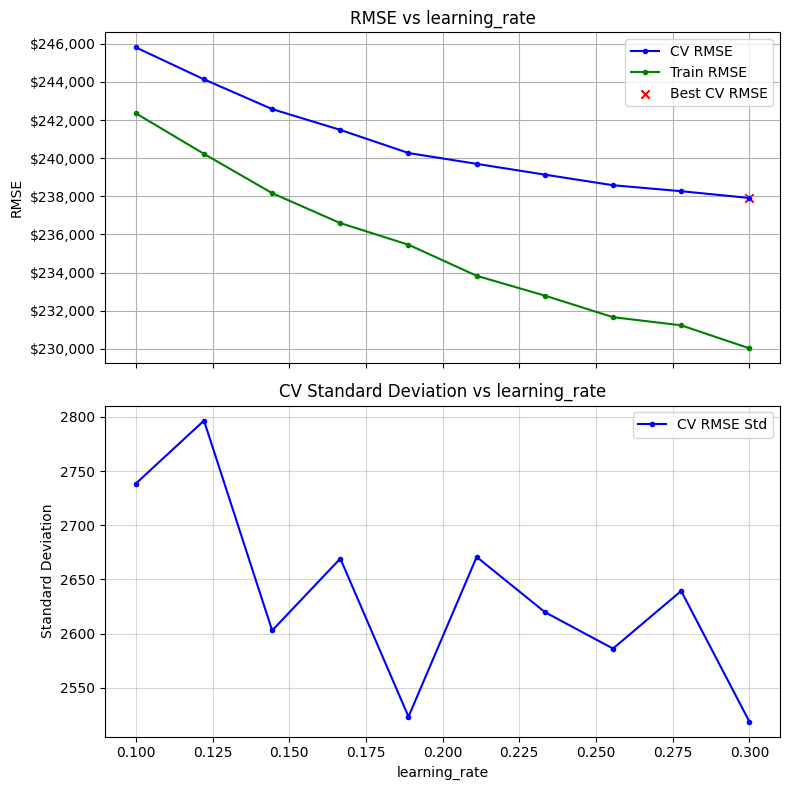

Execution Time: 00:08:59

Parameter learning_rate = 0.3; RMSE = $237,914

[]


Sweeping n_estimators: 100%|██████████| 10/10 [13:27<00:00, 80.75s/it]


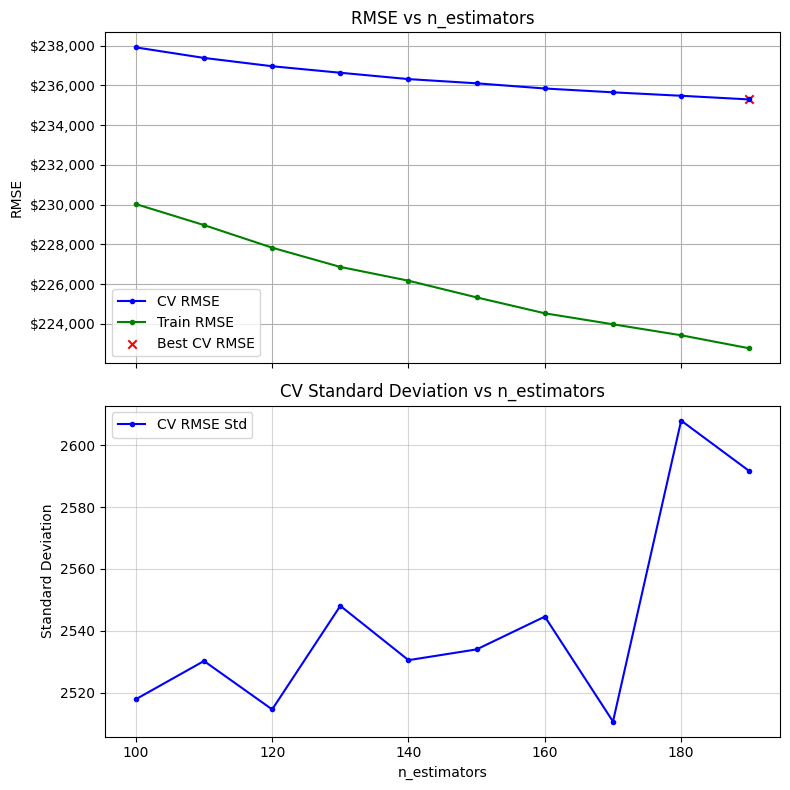

Execution Time: 00:13:27

Parameter n_estimators = 190; RMSE = $235,291

[]


Sweeping max_depth: 100%|██████████| 9/9 [33:10<00:00, 221.16s/it]


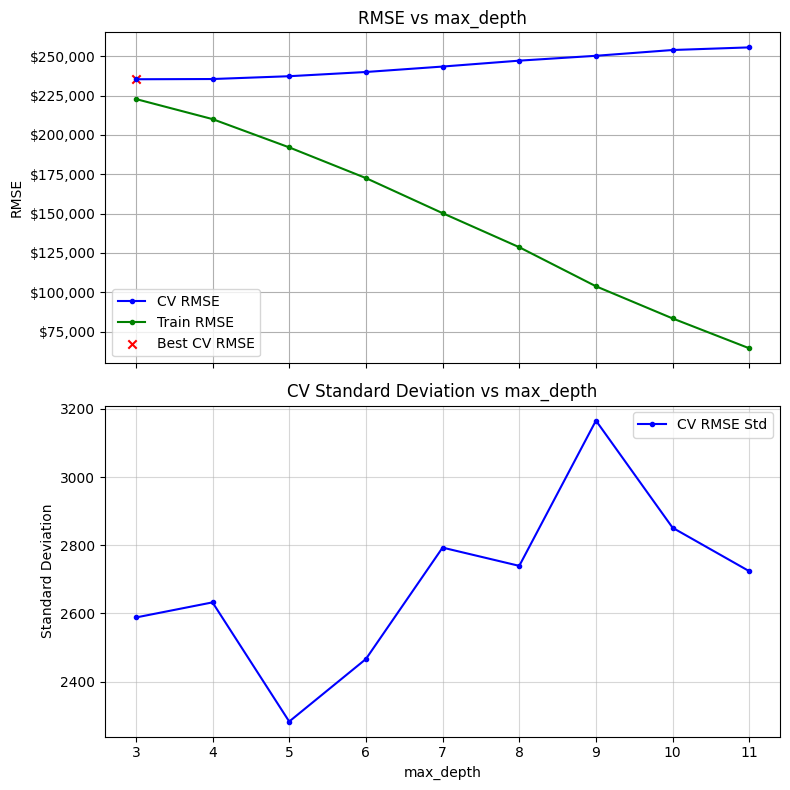

Execution Time: 00:33:10

Parameter max_depth = 3; RMSE = $235,317

[]


Sweeping max_features: 100%|██████████| 10/10 [10:08<00:00, 60.90s/it]


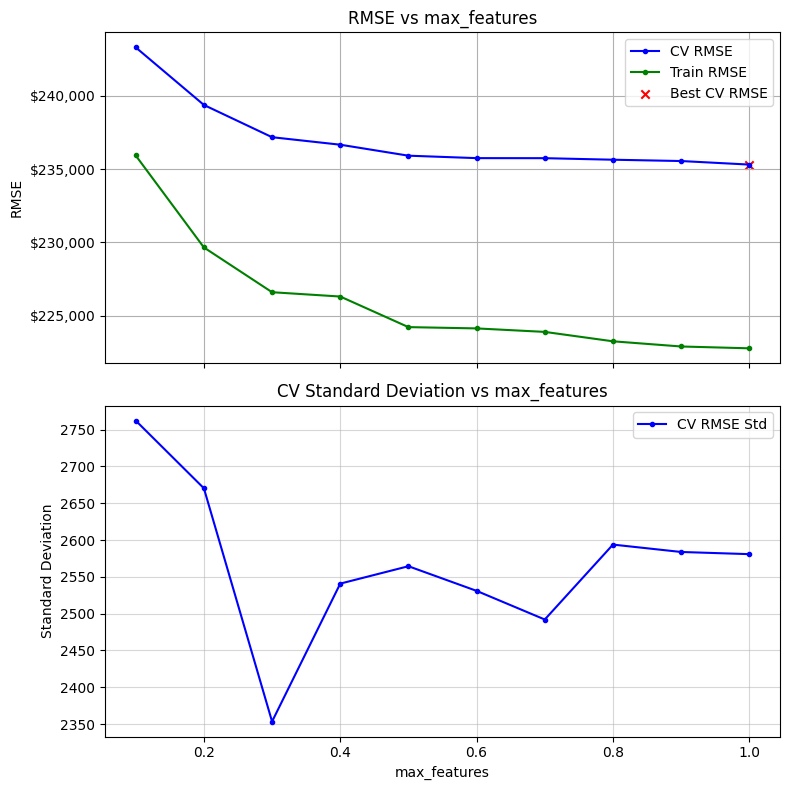

Execution Time: 00:10:09

Parameter max_features = 1.0; RMSE = $235,311

[]


,learning_rate,n_estimators,max_depth,max_features,random_state,RMSE_found
0,0.3,190,3,1.0,42,235310.768588


In [74]:
parameters_and_ranges_gb = [
    ('learning_rate', np.linspace(0.1, 0.3, 10)),
    ('n_estimators', range(100, 200, 10)),
    ('max_depth', range(3, 12, 1)),
    ('max_features', np.linspace(0.1, 1.0, 10)) 
]

for param, parameter_list in parameters_and_ranges_gb:
    Parameters_GB = sweep_parameter(GradientBoostingRegressor,
                                Parameters_GB,
                                param,
                                parameter_list,
                                x_train  = X_train_scaled,
                                y_train  = y_train
                                )

    print(f'\nParameter {param} = {Parameters_GB[param]}; RMSE = {dollar_format(Parameters_GB['RMSE_found'],2)}\n')
    print(Parameters_GB_list)

Parameters_GB_list.append(Parameters_GB)
pd.DataFrame(Parameters_GB_list)

In [78]:
# Grab the parameters for the best gradient boosting model
best_gb_params = Parameters_GB_list[0]

# Evaluate the best gradient boosting model
gb_evaluation = evaluate_model({"Gradient Boosting": GradientBoostingRegressor()}, 
                               X_train_scaled, y_train, **best_gb_params)
gb_evaluation

Evaluating Gradient Boosting…


,Mean CV RMSE,STD CV RMSE,Train RMSE
Model,,,
Gradient Boosting,"$245,816","$2,740","$242,356"


## Final Model Comparison

In [79]:
# Combine all evaluations on for decision tree, bagging and gradient boosting
all_evaluations = pd.concat([dt_best_model, bag_evaluation, gb_evaluation])
all_evaluations

,Mean CV RMSE,STD CV RMSE,Train RMSE
Decision Tree 2,"$259,585","$2,965","$233,854"
Bagging,"$251,908","$2,409","$107,296"
Gradient Boosting,"$245,816","$2,740","$242,356"


### Part 4: Discussion [4 pts]

Reflect on your tuning process and final results:

- What was your tuning strategy for each model? Why did you choose those hyperparameters?
- Did you find that certain types of preprocessing or feature engineering worked better with specific models?
- Provide a ranking of your three models and explain your reasoning — not just based on RMSE, but also interpretability, training time, or generalizability.
- Conclude by considering whether this workflow has produced the results you expected. Typically, you would repeat steps 2 - 4 and also reconsider the choices you made in Milestone 1 when cleaning the dataset, until reaching the point of diminishing returns; do you think that would that have helped here?

### **Answer**
* Tuning strategy and feature engineering:
    - **Decision Tree**: We used grid search for decision tree. Tuning for decision tree started with trying to find the parameter of max_depth, min_sample_leaf, min_sample_split, and max_leaf_nodes by continuously using grid search and dialing in onto the numbers that would give us the smallest RMSE. Once we obtained that, we incorporated the best features from feature selections and performed the same strategy. But only then we were able to find the right hyperparameters. We chose those hyperparameters because they were the default parameters that were able to be adjusted.
   
    - **Bagging**: We started with the default model parameters and began sweeping key hyperparameters such as n_estimators, max_samples, max_features, and bootstrap. We first explored a broad range of values to observe overall performance trends, then gradually narrowed the parameter ranges based on those results to focus on the most promising settings. Considering the running time, we opted for smaller values of n_estimators and max_features unless there was a clear performance gain. We then ran GridSearchCV using a narrowed hyperparameter range and identified the top 10 performing parameter sets. To assess the impact of feature engineering, we repeated the parameter sweeping process using only the best features selected through forward feature selection. However, the results were worse compared to using the full X_train dataset, which aligns with our findings from Part 3. For the Bagging model, it appears that no feature engineering outperforms selective transformation.

    - **Gradient Boosting**: We used parameter sweeps exclusively gradient boosting on the following hyperparameters: learning rate, n estimators, max depth, and max features. The ranges used were conservative and closer to the right side of the range as to speed up evaluation. As a result, estimators and learning rate performed best at the max of their ranges. Max depth reacted different to the data provided as the max depth for tree value was placed at 3, the minimum value in the range. Max features reacted as expected since having all features present in the data provided the best evaluation score. What our group would like to investigate next time would be grid search on the Gradient Boosting Regressor. Together the 4 optimal values did not provide the best Mean CV RMSE, but seaprately, each hyperparameter provided improvements.

* Ranking of three models:
    - Gradient Boost
    - Bagging
    - Decision Tree

    - Reason: Based off the final 3 models, Gradient boosting was the best performing model. It had the best Mean CV RMSE score out of the 3 and a fairly decent STD CV RMSE score also. With more tuning the model might have performed better.

* The choices we made during data cleaning in Milestone 1 and throughout Steps 2 to 4 were really important in shaping the final model. Early on, we removed features with too many missing values or not enough variability, and we also dropped rows that had excessive missing data or were duplicated. These cleaning steps helped improve data quality and model reliability. In addition, we took time to understand the data—looking at distributions (like skewness and outliers) and correlation patterns, including potential multicollinearity—which guided our feature transformation choices in Step 2. From there, Steps 2 to 4 focused on transforming features, selecting the most useful ones, and tuning parameters. These steps helped us decide which features to keep or drop and allowed us to compare strategies by balancing performance improvement, runtime, and model interpretability.